In [7]:
from keras.applications import EfficientNetV2L

In [8]:
INPUT_SHAPE = (224, 224, 3)

- `weights = imagenet` : transfer learning depuis ImageNet
- `include_top = False` : suppression de la dernière couche ([softmax](https://developers.google.com/machine-learning/crash-course/multi-class-neural-networks/softmax?hl=fr))

In [9]:
model = EfficientNetV2L(
    weights="imagenet",
    include_top=False,
    input_shape=INPUT_SHAPE
)

# model.summary()

gel des différentes couches du modèle

In [10]:
nb_layers = 0 # nombre de couches à ré-entrainer
limit = -1 * nb_layers
layers = model.layers if limit == 0 else model.layers[:limit]

for layer in layers: # parcours des différentes couches du modèle
    layer.trainable = False # gel de la couche

on ajoute au modèle pré-entrainé, de nouvelles couches personnalisées
- couches de convolution (filtres appliqués sur l'image)
- couches de pooling (réduisent les dimensions de l'image)

Dans le cas d'une **classification binaire**, la dernière couche (convolutive) utilise `sigmoid` comme fonction d'activation.

Dans le cas d'une **classification multiple**, la dernière couche utilise `softmax` comme fonction d'activation.

In [11]:
from keras.models import Sequential
from keras.layers import *

nb_classes = 4

mon_modele = Sequential([
    model,

    GlobalAveragePooling2D(),

    Dense(512, activation="relu"),
    Dropout(0.2),

    Dense(512, activation="relu"),
    Dropout(0.2),

    Dense(nb_classes, activation="softmax")
])

# mon_modele.summary()

création de deux datasets :
- train (80%)
- test (20%)

In [12]:
import tensorflow as tf

BATCH_SIZE = 4
SEED = 1

train_dataset = tf.keras.utils.image_dataset_from_directory(
    "../data/images",
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(224, 224),
    shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=SEED
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    "../data/images",
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(224, 224),
    shuffle=False,
    validation_split=0.2,
    subset="validation",
    seed=SEED
)

Found 2400 files belonging to 4 classes.
Using 1920 files for training.
Found 2400 files belonging to 4 classes.
Using 480 files for validation.


aperçu des images présentes dans le dataset d'entrainement

In [13]:
# import matplotlib.pyplot as plt
# import numpy as np

# iterator = iter(train_dataset)

# plt.imshow(next(iterator)[0][0].numpy().astype(np.int32))

data augmentation

on enrichi le dataset d'entrainement en appliquant à chaque image des transformations diverses :
- rotation (suivant l'axe y)
- exposition (`delta=0.1`)
- contraste (`constrast_factor=1.75`)

In [14]:
from tensorflow.image import flip_left_right, adjust_brightness, adjust_contrast

def augment(image, label):
    image = flip_left_right(image) # rotation
    image = adjust_brightness(image, delta=0.1) # exposition
    image = adjust_contrast(image, contrast_factor=1.75)

    return (image, label)

train_dataset = train_dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

aperçu des images

In [15]:
# import matplotlib.pyplot as plt
# import numpy as np

# iterator = iter(train_dataset)

# plt.imshow(next(iterator)[0][0].numpy().astype(np.int32))

pour des raisons d'optimisation, on applique des prefetch sur le dataset d'entrainement et le dataset de validation

In [16]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [17]:
validation_dataset = validation_dataset.prefetch(tf.data.AUTOTUNE)
validation_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

compilation du modèle

métriques utilisées :
- accuracy

In [18]:
from keras.metrics import *

metrics = ["accuracy"]

losses
- classification binaire : `BinaryCrossentropy`
- classification multiple : `CategoricalCrossentropy`

In [19]:
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy

mon_modele.compile(
    loss=SparseCategoricalCrossentropy(),
    optimizer=Adam(learning_rate=0.001),
    metrics=metrics
)

création d'un callback qui va arrêter l'entrainement sous certaines conditions

métrique surveillée : `val_loss`

`patience=3` : nombre d'époques consécutives où la métrique n'évolue plus

In [20]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(patience=3, monitor="val_loss")

entrainement du modèle

In [34]:
historique = mon_modele.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=[early_stop]
)

Epoch 1/10
480/480 [==============================] - 614s 1s/step - loss: 0.0918 - accuracy: 0.9734 - val_loss: 0.1651 - val_accuracy: 0.9521
Epoch 2/10
480/480 [==============================] - 617s 1s/step - loss: 0.0873 - accuracy: 0.9740 - val_loss: 0.1058 - val_accuracy: 0.9646
Epoch 3/10
480/480 [==============================] - 615s 1s/step - loss: 0.0600 - accuracy: 0.9833 - val_loss: 0.0466 - val_accuracy: 0.9854
Epoch 4/10
480/480 [==============================] - 783s 2s/step - loss: 0.0577 - accuracy: 0.9802 - val_loss: 0.0901 - val_accuracy: 0.9771
Epoch 5/10
480/480 [==============================] - 682s 1s/step - loss: 0.0948 - accuracy: 0.9781 - val_loss: 0.0718 - val_accuracy: 0.9833
Epoch 6/10
480/480 [==============================] - 565s 1s/step - loss: 0.0296 - accuracy: 0.9891 - val_loss: 0.0607 - val_accuracy: 0.9896


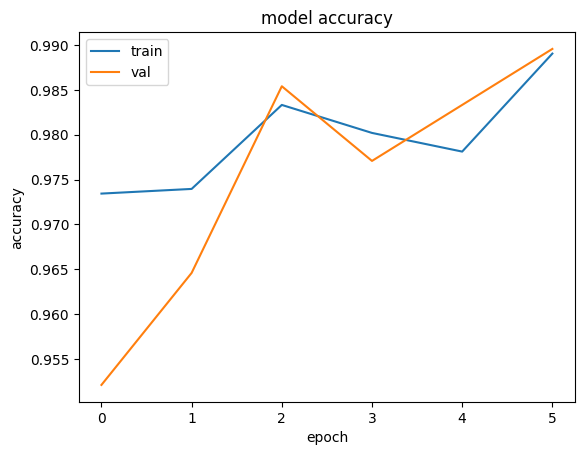

In [35]:
from matplotlib import pyplot as plt
plt.plot(historique.history['accuracy'])
plt.plot(historique.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

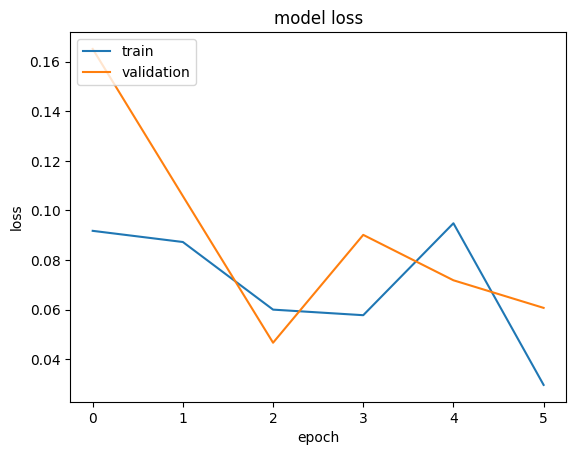

In [36]:
plt.plot(historique.history['loss'])
plt.plot(historique.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [22]:
# commande pour sauvegarder le modèle créé
# mon_modele.save("mon_modele.hdf5")
# pour charger le modèle
# tf.keras.models.load_model('my_model.h5')

test du modèle

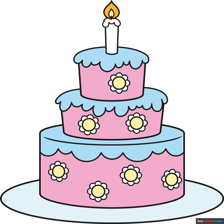

In [52]:
from PIL import Image

image = Image.open("test_images/test_cake_2.jpg")
image = image.resize((224, 224))
image

In [53]:
import numpy as np

image = np.asarray(image)
# classes = {
#     0: "cake",
#     1: "pizza",
#     2: "sunflower",
#     3: "tulips",
# }
classes = tf.keras.preprocessing.image_dataset_from_directory("../data/images/").class_names
prediction = mon_modele.predict(np.array([image]))
index = np.argmax(prediction)
print(prediction)
classes[index]

Found 2400 files belonging to 4 classes.
1/1 [==============================] - 0s 381ms/step
[[1.0000000e+00 1.6589505e-12 2.4422131e-18 2.6730268e-15]]


'cake'